In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


In [2]:

def show_images(images):
    
    images=np.reshape(images,[-1,32,32,3])
    #print(images.shape)
    
    for i in range(images.shape[0]):
        idx=i+1
        plt.subplot(7,1, idx)
        
        plt.imshow(preprocess_img(images[i,:,:,1].astype('int32')))
        
        plt.axis('off')
    plt.show()
        
    return

In [4]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)


In [5]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    #pass
    return tf.maximum(x,alpha*x)

In [7]:
def sample_noise(batch_size, dim):
    
    random_noise = tf.random_uniform(maxval=1,minval=-1,shape=[batch_size, dim])
    
    return random_noise

In [9]:
def discriminator(x):
   
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        #pass
        fc_1=tf.layers.dense(x,units=256,activation=leaky_relu)
        
        fc_2=tf.layers.dense(fc_1,units=256,activation=leaky_relu)
        
        logits=tf.layers.dense(fc_2,units=1)
        
        return logits

In [11]:
def generator(z):
  
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        #pass
        #32,32,3
        
        fc_1=tf.layers.dense(z,units=1024,activation=tf.nn.relu)
        
        fc_2=tf.layers.dense(fc_1,units=1024,activation=tf.nn.relu)
        #fc_3=tf.layers.dense(fc_2,units=784)#
        fc_3=tf.layers.dense(fc_2,units=3072)#
        
        
        img=tf.nn.tanh(fc_3)
       # print(img)
        return img

In [10]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


In [12]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Incorrect number of parameters in generator. 4203520 instead of 1858320. Check your achitecture.


In [13]:
def gan_loss(logits_real, logits_fake):

    true_labels = tf.ones_like(logits_fake)
    
    # DISCRIMINATOR loss has 2 parts: how well it classifies real images and how well it
    # classifies fake images.
    real_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=true_labels)
    fake_image_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=1-true_labels)
    
    # Combine and average losses over the batch
    D_loss = real_image_loss + fake_image_loss 
    D_loss = tf.reduce_mean(D_loss)
    
    # GENERATOR is trying to make the discriminator output 1 for all its images.
    # So we use our target label vector of ones for computing generator loss.
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=true_labels)
    
    # Average generator loss over the batch.
    G_loss = tf.reduce_mean(G_loss)
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [14]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 7.19722e-17


In [15]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):

    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    #pass
    return D_solver, G_solver

In [16]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 3072])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)
#scale images to be -1 to 1

with tf.variable_scope("") as scope:
    
    logits_real = discriminator(preprocess_img(x))
    #tf.variable_Scope reate a new variable with such name or retrieve the one that was created before. 
    
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    
    logits_fake = discriminator(G_sample)

# Get the list of variables/Weights/Parameters for the discriminator and generator

##TensorFlow provides graph collections that group the variables.
##To access the variables that were trained you would call tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
##or to get all variables(including some for statistics) use tf.get_collection(tf.GraphKeys.VARIABLES)
##or its shorthand tf.all_variables()

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

In [18]:

train_indicies=np.arange(X_train.shape[0])
np.random.shuffle(train_indicies)

In [23]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    
    # compute the number of iterations we need
    max_iter = int(X_train.shape[0]/batch_size)
    for epoch in range(num_epoch):
        for it in range(max_iter):
            # every show often, show a sample result
            if it % show_every == 0:
                samples = sess.run(G_sample)
                fig = show_images(samples[:7])
                plt.show()
                print()

            # run a batch of data through the network
            #minibatch,minbatch_y = mnist.train.next_batch(batch_size)
            start_idx=(it*batch_size)%X_train.shape[0]
            
            idx=train_indicies[start_idx:start_idx+batch_size]

            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: X_train[idx]})#unsupervised
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))

    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()
    return samples

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

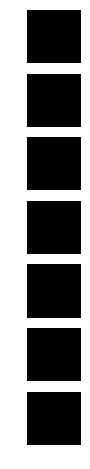


Iter: 0, D: 104.8, G:0.6843
Iter: 50, D: 1.19, G:1.488
Iter: 100, D: 0.5865, G:1.285
Iter: 150, D: 0.4962, G:1.612
Iter: 200, D: 0.6209, G:2.738


KeyboardInterrupt: 

In [24]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
sample=run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)